In [1]:
# import modules
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.merge import merge
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import TwoSlopeNorm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import os 
import io
import re
import math
from rasterio.transform import rowcol
import requests
import matplotlib.patches as mpatches
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import fiona
from matplotlib_scalebar.scalebar import ScaleBar
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import time
print("import modules")

# set parameters and file paths, this needs to be set up so it can loop through all groups
domain = "Rockies"
outputWorkspace = f"D:/ASOML/{domain}/modelOutputs/fromAlpine/"
testGroupWS = f"D:/ASOML/{domain}/test_groups/"
snotelWS = testGroupWS + "snotel_data/"
metaCSV = testGroupWS + "testGroupMetadata.csv"
aspect_CON = r"D:\ASOML\Rockies\features\ASO_CON_aspect_albn83_60m.tif"
elev_path = r"D:\ASOML\Rockies\features\ASO_CON_dem_albn83_60m.tif"
basemap = f"D:/ASOML/{domain}/basemap_data/"
features_binned = f"D:/ASOML/{domain}/features/binned/"
directionary_path = features_binned + "binned_raster_legends.csv"
snotelMeta = testGroupWS + "snotel_metaData.csv"
snotel_shp = basemap + "WW_CDEC_SNOTEL_geon83.shp"

# groups
interation = "20250529_165833"
groups = ["G1", "G2", "G3", "G4", "G5", "G6"]
group = "G5"

# for group in groups:

# grab valid file path
vettingWS = f"{outputWorkspace}/{interation}/outTifs_{group}_yPreds_tifs/vetting/"
meta_df = pd.read_csv(metaCSV)
meta_df = meta_df[meta_df['GroupNum'] == f"{group}"]
year = meta_df.iloc[0]['Year']
trainA_doy = meta_df.iloc[0]['TrainDOYA']
trainA_basin = meta_df.iloc[0]['TrainBasinA']
trainB_doy = meta_df.iloc[0]['TrainDOYB']
trainB_basin = meta_df.iloc[0]['TrainBasinB']
test_doy = meta_df.iloc[0]['TestDOY']
test_basin = meta_df.iloc[0]['TestBasin']
validASO = f"D:/ASOML/{domain}/{year}/SWE_processed/{test_basin}_{test_doy}_albn83_60m_SWE.tif"
CNN_out = f"{outputWorkspace}/{interation}/outTifs_{group}_yPreds_tifs/mosaic_output/{interation}_{group}_cosine_mosaic_align.tif"
trainA = f"D:/ASOML/{domain}/{year}/SWE_processed/{trainA_basin}_{trainA_doy}_albn83_60m_SWE.tif"
trainB = f"D:/ASOML/{domain}/{year}/SWE_processed/{trainB_basin}_{trainB_doy}_albn83_60m_SWE.tif"
print(test_doy)

def safe_read_shapefile(path):
        with fiona.open(path, 'r') as src:
            return gpd.GeoDataFrame.from_features(src, crs=src.crs)

import modules
2025104


In [2]:
import os
import re
import io
import requests
import pandas as pd

def download_and_merge_snotel_data(id_list, state_list, start_date, end_date, output_dir):
    merged_csv_path = os.path.join(output_dir, f"merged_snotel_{end_date}.csv")
    
    # Skip if already downloaded
    if os.path.exists(merged_csv_path):
        print("Sensors already downloaded.")
        return pd.read_csv(merged_csv_path)
    
    print("Downloading SNOTEL data...")

    for ids, state in zip(id_list, state_list):
        if ids == 0:
            continue

        url = (
            f"https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/"
            f"start_of_period/{ids}:{state}:SNTL%257Cid=%2522%2522%257Cname/"
            f"{start_date},{end_date}/stationId,name,WTEQ::value?fitToScreen=false"
        )

        try:
            response = requests.get(url)
            response.raise_for_status()
            
            # Filter lines
            lines = response.text.splitlines()
            filtered_lines = [line for line in lines if not line.lstrip().startswith('#')]
            filtered_csv = "\n".join(filtered_lines)
            
            df = pd.read_csv(io.StringIO(filtered_csv))

            # Find SWE column
            matching_cols = [col for col in df.columns if "Snow Water Equivalent" in col]
            if matching_cols:
                col = matching_cols[0]
                match = re.search(r'\(([^)]+)\)', col)
                new_col_name = match.group(1) if match else col
                df = df.rename(columns={col: new_col_name})

            # Save to temp CSV
            temp_csv_path = os.path.join(output_dir, f"snotel_{ids}_{state}_{end_date}.csv")
            df.to_csv(temp_csv_path, index=False)

        except Exception as ex:
            print(f"Error downloading {ids}, {state}: {ex}")
            continue

    # Merge downloaded CSVs
    csv_files = [f for f in os.listdir(output_dir) if f.startswith("snotel") and f.endswith(".csv")]
    merged_df = None

    for file in csv_files:
        file_path = os.path.join(output_dir, file)
        try:
            df = pd.read_csv(file_path)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
            continue

        df.columns = [col.strip() for col in df.columns]
        if 'Date' not in df.columns:
            print(f"Skipping file without 'Date' column: {file}")
            continue

        sensor_name = os.path.splitext(file)[0].split("_")[1]
        data_cols = [col for col in df.columns if col != 'Date']
        if not data_cols:
            print(f"No SWE column in file: {file}")
            continue

        df = df[['Date', data_cols[0]]].rename(columns={data_cols[0]: sensor_name})

        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='Date', how='outer')

    # Save and clean up
    if merged_df is not None:
        merged_df.to_csv(merged_csv_path, index=False)
        print(f"Merged CSV saved to: {merged_csv_path}")
    else:
        print("No dataframes merged.")
        return pd.DataFrame()  # return empty df

    # Delete intermediate files
    for file in os.listdir(output_dir):
        if file.startswith("snotel") and not file.startswith("merged"):
            os.remove(os.path.join(output_dir, file))

    return merged_df

In [3]:
def get_snotel_raster_values(raster_path, shp, value_threshold=0, value_column="raster_val"):
    with rasterio.open(raster_path) as src:
        raster = src.read(1)
        raster_crs = src.crs
        raster_transform = src.transform
        raster_nodata = src.nodata
        raster_bounds = src.bounds

        # Reproject shapefile to match raster
        shp_proj = shp.to_crs(raster_crs)

        valid_rows = []
        raster_values = []

        for idx, row in shp_proj.iterrows():
            x, y = row.geometry.x, row.geometry.y

            # Skip if outside raster bounds
            if not (raster_bounds.left <= x <= raster_bounds.right and
                    raster_bounds.bottom <= y <= raster_bounds.top):
                continue

            try:
                r, c = rowcol(raster_transform, x, y)

                # Check if inside raster shape
                if r < 0 or r >= raster.shape[0] or c < 0 or c >= raster.shape[1]:
                    continue

                val = raster[r, c]

                # Validate value
                if (
                    val is not None and
                    (raster_nodata is None or val != raster_nodata) and
                    val > value_threshold
                ):
                    valid_rows.append(row)
                    raster_values.append(val)

            except (IndexError, ValueError):
                continue

    # Build GeoDataFrame with raster values
    if valid_rows:
        gdf = gpd.GeoDataFrame(valid_rows, crs=shp_proj.crs)
        gdf[value_column] = raster_values
        print(f"Found {len(gdf)} valid points with raster values from {raster_path}")
    else:
        gdf = gpd.GeoDataFrame(columns=shp_proj.columns, crs=shp_proj.crs)
        gdf[value_column] = []  # still add the column for consistency
        print(f"No valid points found in {raster_path}")

    return gdf

In [4]:
# grab snotel metadata
snotel_df = pd.read_csv(snotelMeta)
id_list = snotel_df["site_id"].tolist()
state_list = snotel_df["state_id"].tolist()

# convert from doy to yyyy-mm-dd
test_date_obj = datetime.strptime(str(test_doy), "%Y%j")
sens_startObj = test_date_obj - timedelta(days=7)
test_end_date= test_date_obj.strftime("%Y-%m-%d")
test_start_date = sens_startObj.strftime("%Y-%m-%d")

# convert from doy to yyyy-mm-dd
trnA_date_obj = datetime.strptime(str(trainA_doy), "%Y%j")
sensA_startObj = trnA_date_obj - timedelta(days=7)
trnA_end_date= trnA_date_obj.strftime("%Y-%m-%d")
trnA_start_date = sensA_startObj.strftime("%Y-%m-%d")

# convert from doy to yyyy-mm-dd
trnB_date_obj = datetime.strptime(str(trainB_doy), "%Y%j")
sensB_startObj = trnB_date_obj - timedelta(days=7)
trnB_end_date= trnB_date_obj.strftime("%Y-%m-%d")
trnB_start_date = sensB_startObj.strftime("%Y-%m-%d")

In [5]:
merged_test = download_and_merge_snotel_data(
    id_list=id_list,
    state_list=state_list,
    start_date=test_start_date,
    end_date=test_end_date,
    output_dir=snotelWS
)

merged_trainA = download_and_merge_snotel_data(
    id_list=id_list,
    state_list=state_list,
    start_date=trnA_start_date,
    end_date=trnA_end_date,
    output_dir=snotelWS
)

merged_trainB = download_and_merge_snotel_data(
    id_list=id_list,
    state_list=state_list,
    start_date=trnB_start_date,
    end_date=trnB_end_date,
    output_dir=snotelWS
)

Sensors already downloaded.
Sensors already downloaded.
Sensors already downloaded.


In [6]:
snotelSHP = safe_read_shapefile(snotel_shp)
gdf_valid = get_snotel_raster_values(validASO, snotelSHP, value_column="aso_val")
gdf_CNN = get_snotel_raster_values(CNN_out, snotelSHP, value_column="cnn_val")
gdf_trainA = get_snotel_raster_values(trainA, snotelSHP, value_column="trainA")
gdf_trainB = get_snotel_raster_values(trainB, snotelSHP, value_column="trainB")

Found 5 valid points with raster values from D:/ASOML/Rockies/2025/SWE_processed/UintaMountains_2025104_albn83_60m_SWE.tif
Found 5 valid points with raster values from D:/ASOML/Rockies/modelOutputs/fromAlpine//20250529_165833/outTifs_G5_yPreds_tifs/mosaic_output/20250529_165833_G5_cosine_mosaic_align.tif
Found 5 valid points with raster values from D:/ASOML/Rockies/2025/SWE_processed/RoaringFork_2025102_albn83_60m_SWE.tif
Found 3 valid points with raster values from D:/ASOML/Rockies/2025/SWE_processed/StVrainLefthand_2025101_albn83_60m_SWE.tif


In [7]:
# arranging the sensor shapefile for the sensors
filtered_df = merged_test[merged_test['Date'] == test_end_date]
sensor_cols = [col for col in filtered_df.columns if col !="Date"]
long_df = filtered_df.melt(id_vars=['Date'], value_vars=sensor_cols,
                        var_name="site_id", value_name="snotel_SWE")

In [8]:
# arranging geodatabase for the scatter plot
gdf_valid = gdf_valid[["site_id", "aso_val"]]
gdf_valid['ASO_SWE'] = gdf_valid['aso_val']*39.3701
gdf_valid['Date'] = test_end_date

gdf_CNN = gdf_CNN[["site_id", "cnn_val"]]
gdf_CNN['CNN_SWE'] = gdf_CNN['cnn_val']*39.3701
gdf_CNN['Date'] = test_end_date

gdf_valid['site_id'] = gdf_valid['site_id'].astype(str)
long_df['site_id'] = long_df['site_id'].astype(str)
gdf_CNN['site_id'] = gdf_CNN['site_id'].astype(str)
scatter = pd.merge(long_df, gdf_valid[['site_id', 'ASO_SWE']], on='site_id', how='left')
scatter = pd.merge(scatter, gdf_CNN[['site_id', 'CNN_SWE']], on='site_id', how='left')
scatter = scatter.dropna()

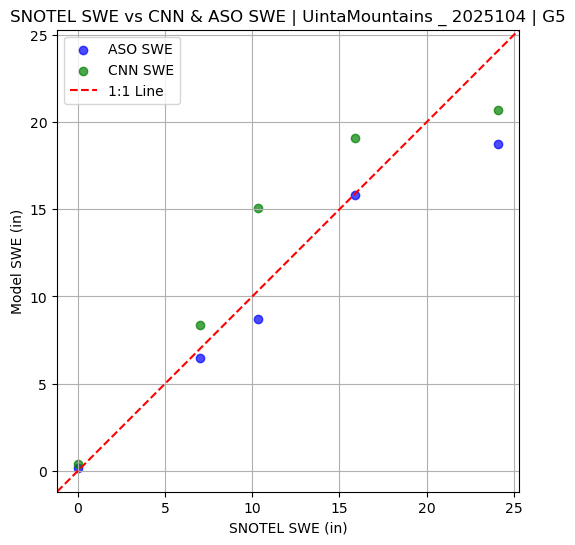

In [9]:
# make a scatter plot
CNN_Output = scatter["CNN_SWE"]
ASO_Output = scatter["ASO_SWE"]
SNOTEL = scatter["snotel_SWE"]
plt.figure(figsize=(6,6))

# Plot ASO vs SNOTEL
plt.scatter(SNOTEL, ASO_Output, alpha=0.7, color='blue', label='ASO SWE')

# Plot CNN vs SNOTEL
plt.scatter(SNOTEL, CNN_Output, alpha=0.7, color='green', label='CNN SWE')

# Plot 1:1 line
min_val = min(SNOTEL.min(), CNN_Output.min(), ASO_Output.min())
max_val = max(SNOTEL.max(), CNN_Output.max(), ASO_Output.max())
padding = 0.05 * (max_val - min_val)
lims = [min_val - padding, max_val + padding]
plt.plot(lims, lims, 'r--', label='1:1 Line')

# Labels and styling
plt.xlabel('SNOTEL SWE (in)')
plt.ylabel("Model SWE (in)")
plt.title(f'SNOTEL SWE vs CNN & ASO SWE | {test_basin} _ {test_doy} | {group}')
plt.legend()
plt.grid(True)
plt.axis('square')  
plt.xlim(lims)
plt.ylim(lims)
plt.savefig(vettingWS + f"ASOvCNN_scatterPlot_{interation}_{test_basin}_{test_doy}_{group}.png")
plt.show()

In [10]:
sensors = gdf_valid['site_id'].tolist()
sensors.append("Date")
sensors_sub = merged_test[sensors]

cols = sensors_sub.columns.tolist()
if "Date" in cols:
    cols.insert(0, cols.pop(cols.index("Date")))  # move Date to front
    sensors_sub = sensors_sub[cols]

In [11]:
## test data
# Get sensor IDs from gdf_valid and subset data
merged_test.columns = merged_test.columns.astype(str)
sens_test = gdf_valid['site_id'].astype(str).tolist()
sens_test.append("Date")
sensors_test = merged_test[sens_test].copy()

# Ensure 'Date' is first column
cols = sensors_test.columns.tolist()
if "Date" in cols:
    cols.insert(0, cols.pop(cols.index("Date")))
    sensors_test = sensors_test[cols]

# Rename columns for clarity (optional)
sensors_test = sensors_test.rename(columns={col: f"# {col}" for col in sensors_test.columns if col != "Date"})
sensors_test.columns = sensors_test.columns.str.strip()

## TrainA
# Get sensor IDs from gdf_valid and subset data
merged_trainA.columns = merged_trainA.columns.astype(str)
sens_trainA = gdf_trainA['site_id'].astype(str).tolist()
sens_trainA.append("Date")
sens_trainA = merged_trainA[sens_trainA].copy()

# Ensure 'Date' is first column
cols = sens_trainA.columns.tolist()
if "Date" in cols:
    cols.insert(0, cols.pop(cols.index("Date")))
    sens_trainA = sens_trainA[cols]

# Rename columns for clarity (optional)
sens_trainA = sens_trainA.rename(columns={col: f"# {col}" for col in sens_trainA.columns if col != "Date"})
sens_trainA.columns = sens_trainA.columns.str.strip()

## TrainB
# Get sensor IDs from gdf_valid and subset data
merged_trainB.columns = merged_trainB.columns.astype(str)
sens_trainB = gdf_trainB['site_id'].astype(str).tolist()
sens_trainB.append("Date")
sens_trainB = merged_trainB[sens_trainB].copy()

# Ensure 'Date' is first column
cols = sens_trainB.columns.tolist()
if "Date" in cols:
    cols.insert(0, cols.pop(cols.index("Date")))
    sens_trainB = sens_trainB[cols]

# Rename columns for clarity (optional)
sens_trainB = sens_trainB.rename(columns={col: f"# {col}" for col in sens_trainB.columns if col != "Date"})
sens_trainB.columns = sens_trainB.columns.str.strip()

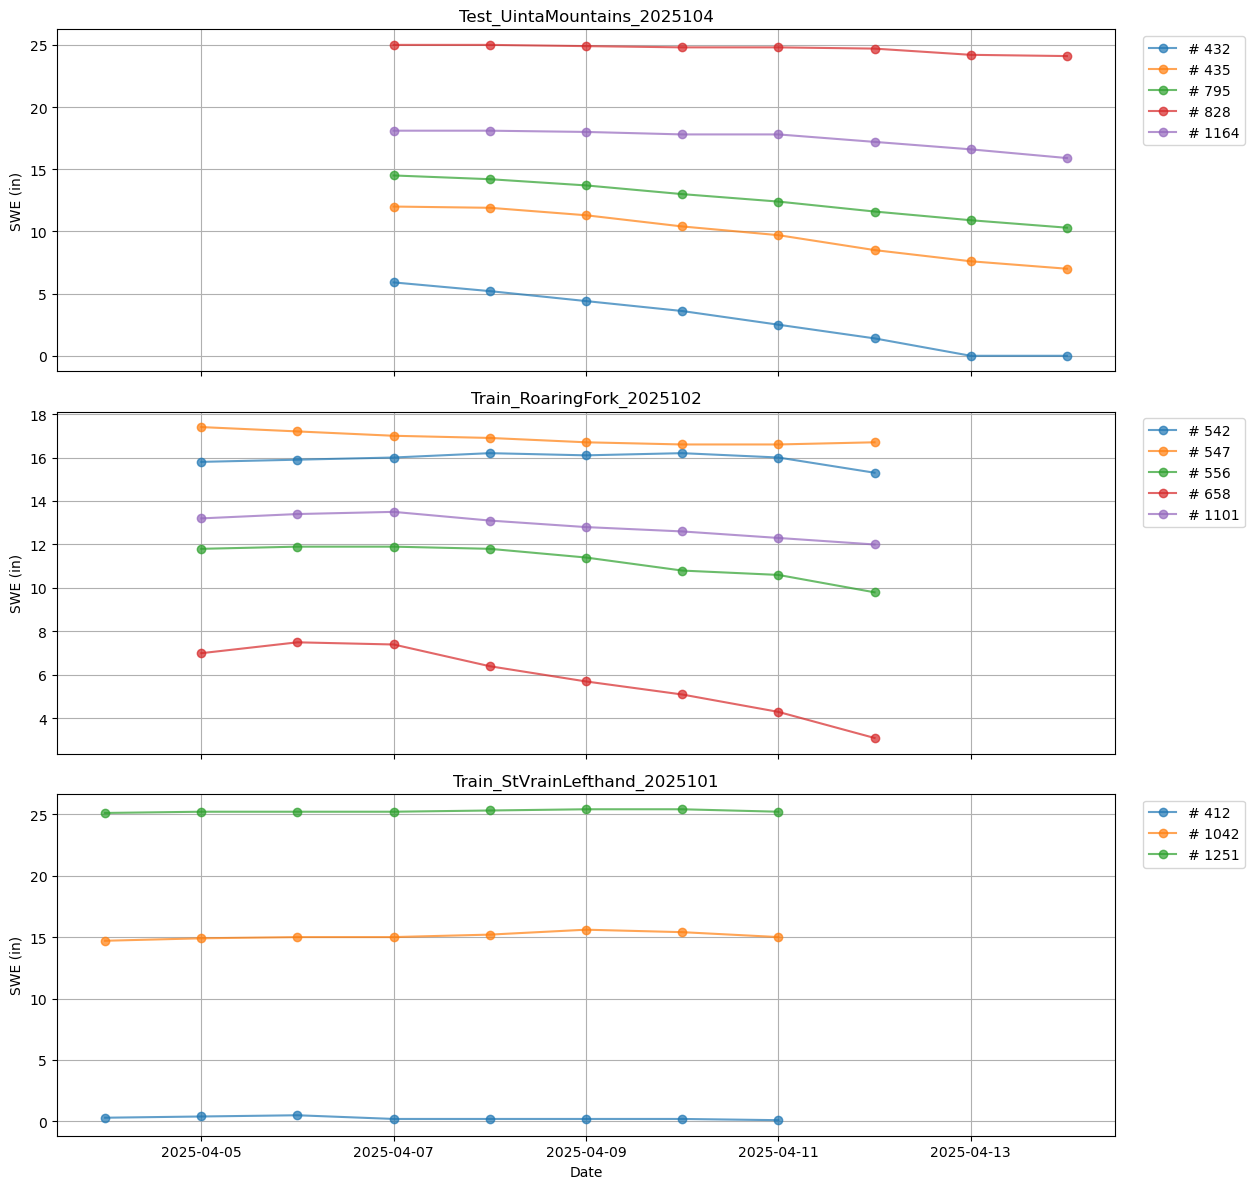

In [12]:
# Optional: make sure dates are datetime
for df in [sensors_test, sens_trainA, sens_trainB]:
    df["Date"] = pd.to_datetime(df["Date"])

# Setup figure with 3 rows, 1 column
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Set of tuples: (dataframe, axis, title)
groups = [
    (sensors_test, axes[0], f"Test_{test_basin}_{test_doy}"),
    (sens_trainA, axes[1], f"Train_{trainA_basin}_{trainA_doy}"),
    (sens_trainB, axes[2], f"Train_{trainB_basin}_{trainB_doy}"),
]

# Plot each group
for df, ax, title in groups:
    for col in df.columns:
        if col != "Date":
            ax.plot(df["Date"], df[col], label=col, marker='o', alpha=0.7)
    ax.set_title(title)
    ax.set_ylabel("SWE (in)")
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), ncol=1)
    ax.grid(True)

# Final formatting
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.subplots_adjust(right=0.8)  
plt.savefig(vettingWS + f"SNOTELtimeseries_{interation}_{test_basin}_{test_doy}_{group}.png")
plt.show()